In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

In [4]:
# define the target variable
target_feature = "SalePrice"

# Load the dataset
train = pd.read_csv('C:\\Users\\ajroy\\OneDrive\\Desktop\\mypython.py\\house_price_predection\\data\\USA Housing Dataset.csv')
test = pd.read_csv('C:\\Users\\ajroy\\OneDrive\\Desktop\\mypython.py\\house_price_predection\\data\\USA Housing Dataset.csv')
print(f'train.shape: {train.shape}')
print(f'test.shape : {test.shape}')

train.shape: (4140, 18)
test.shape : (4140, 18)


In [5]:
test.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-09 00:00:00,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA


In [6]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-09 00:00:00,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA


In [12]:


def split_data_X_y(df, target_feature):
    df = df.copy()
    if target_feature not in df.columns:
        raise KeyError(f"target_feature '{target_feature}' not in DataFrame columns")
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    return X, y

def split_data_train_test(df, target_feature, test_size=0.2, stratify=False):
    X, y = split_data_X_y(df, target_feature)
    strat = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=strat
    )
    return X_train, X_test, y_train, y_test

def get_categorical_features(df):
    # return only object and category types (commonly used for categorical)
    return df.select_dtypes(include=['object','category']).columns

def get_numerical_features(df):
    return df.select_dtypes(include=[np.number]).columns

def show_dtypes(df):
    pd.set_option('display.max_colwidth', None)
    # group column names by dtype
    groups = df.columns.to_series().groupby(df.dtypes).agg(list)
    out = pd.DataFrame({
        'dtype': groups.index.astype(str),
        '# columns': groups.apply(len).values,
        'columns': groups.values
    })
    return out.style.set_properties(subset=['columns'], **{'text-align':'left'})

def generate_summary_table(df, nunique_threshold=100):
    num_cols = set(get_numerical_features(df))
    rows = []
    for col in df.columns:
        s = df[col]
        is_num = col in num_cols
        uniq = s.nunique(dropna=False)
        mode_val = s.mode()[0] if not s.mode().empty else np.nan
        mode_count = s.value_counts(dropna=False).max() if not s.value_counts(dropna=False).empty else 0
        mode_pct = round(mode_count * 100 / len(df), 1) if len(df) > 0 else 0

        row = {
            'column': col,
            'dtype': s.dtype,
            'count': s.count(),
            'mean': round(s.mean(), 1) if is_num else '',
            'std': round(s.std(), 1) if is_num else '',
            'min': round(s.min(), 1) if is_num else '',
            '25%': round(s.quantile(0.25), 1) if is_num else '',
            '50%': round(s.median(), 1) if is_num else '',
            '75%': round(s.quantile(0.75), 1) if is_num else '',
            'max': round(s.max(), 1) if is_num else '',
            'nunique': uniq,
            'unique': list(s.unique()) if uniq < nunique_threshold else '',
            'mode': mode_val,
            'mode #': int(mode_count),
            'mode %': mode_pct,
            'null #': int(s.isnull().sum()),
            'null %': round(s.isnull().mean() * 100, 1)
        }
        rows.append(row)

    summary_table = pd.DataFrame(rows)
    summary_table = summary_table.sort_values(by='dtype')
    return summary_table

def plot_missing_values(nan_df, figsize=(12,4)):
    # Expect nan_df to have columns ['column', 'null %']
    plt.figure(figsize=figsize)
    sns.barplot(x='column', y='null %', data=nan_df)
    plt.title("Percentage of missing values in data")
    plt.xlabel("Data columns")
    plt.ylabel("Percentage %")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [11]:
show_dtypes(train)

,dtype,# columns,columns
0,int64,9,"['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']"
1,float64,4,"['price', 'bedrooms', 'bathrooms', 'floors']"
2,object,5,"['date', 'street', 'city', 'statezip', 'country']"


In [8]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)

# Format and print the categorical features
print(f"Categorical Features: ({len(categorical_features)})")
print("  " + ", ".join(categorical_features))

# Add a separator for better readability
print("\n" + "-"*40 + "\n")

# Format and print the numerical features
print(f"Numerical Features: ({len(numerical_features)})")
print("  " + ", ".join(numerical_features))

Categorical Features: (5)
  date, street, city, statezip, country

----------------------------------------

Numerical Features: (13)
  price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated


In [9]:
train[numerical_features].head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0
1,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0
2,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0
3,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0
4,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0


In [10]:
train[categorical_features].head()

,date,street,city,statezip,country
0,2014-05-09 00:00:00,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,10834 31st Ave SW,Seattle,WA 98146,USA


In [13]:
# Check for duplicate rows
duplicate_rows = train[train.duplicated()]
print("Duplicate rows:")
print(duplicate_rows)

Duplicate rows:
Empty DataFrame
Columns: [date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated, street, city, statezip, country]
Index: []


In [14]:
generate_summary_table(train[numerical_features])

,column,dtype,count,mean,std,min,25%,50%,75%,max,nunique,unique,mode,mode #,mode %,null #,null %
3,sqft_living,int64,4140,2143.6,957.5,370.0,1470.0,1980.0,2620.0,10040.0,549,,1720.0,31,0.7,0,0.0
4,sqft_lot,int64,4140,14697.6,35876.8,638.0,5000.0,7676.0,11000.0,1074218.0,2856,,5000.0,69,1.7,0,0.0
6,waterfront,int64,4140,0.0,0.1,0.0,0.0,0.0,0.0,1.0,2,"[0, 1]",0.0,4109,99.3,0,0.0
7,view,int64,4140,0.2,0.8,0.0,0.0,0.0,0.0,4.0,5,"[0, 4, 1, 2, 3]",0.0,3722,89.9,0,0.0
8,condition,int64,4140,3.5,0.7,1.0,3.0,3.0,4.0,5.0,5,"[3, 5, 4, 2, 1]",3.0,2596,62.7,0,0.0
9,sqft_above,int64,4140,1831.4,861.4,370.0,1190.0,1600.0,2310.0,8020.0,491,,1200.0,43,1.0,0,0.0
10,sqft_basement,int64,4140,312.3,464.3,0.0,0.0,0.0,602.5,4820.0,205,,0.0,2476,59.8,0,0.0
11,yr_built,int64,4140,1970.8,29.8,1900.0,1951.0,1976.0,1997.0,2014.0,115,,2005.0,96,2.3,0,0.0
12,yr_renovated,int64,4140,808.4,979.4,0.0,0.0,0.0,1999.0,2014.0,60,"[0, 2007, 2003, 2006, 1970, 2009, 1990, 1994, ...",0.0,2462,59.5,0,0.0
0,price,float64,4140,553062.9,583686.5,0.0,320000.0,460000.0,659125.0,26590000.0,1625,,0.0,49,1.2,0,0.0


In [21]:
# show columns with null more than 5%
if nan_df.shape[0] == 0:
    print("No columns with more than 5% missing values.")
else:
    plot_missing_values(nan_df)


No columns with more than 5% missing values.


In [22]:
(train.isnull().mean() * 100).round(2)


date             0.0
price            0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
street           0.0
city             0.0
statezip         0.0
country          0.0
dtype: float64

In [23]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)

# Format and print the categorical features
print(f"Categorical Features: ({len(categorical_features)})")
print("  " + ", ".join(categorical_features))

# Add a separator for better readability
print("\n" + "-"*40 + "\n")

# Format and print the numerical features
print(f"Numerical Features: ({len(numerical_features)})")
print("  " + ", ".join(numerical_features))

Categorical Features: (5)
  date, street, city, statezip, country

----------------------------------------

Numerical Features: (13)
  price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated


In [24]:
# Distribution Plots:
def plot_histplot(df, col, ax):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram Plot of {col}')
def plot_distplot(df, col, ax):
    sns.distplot(df[col], ax=ax)
    ax.set_title(f'Distribution Plot of {col}')
def plot_kdeplot(df, col, ax):
    sns.kdeplot(df[col], ax=ax, fill=True)
    ax.set_title(f'KDE Plot of {col}')
    
# Categorical Plots:
def plot_pie_chart(df, col, ax):
    labels = df[col].value_counts()
    ax.pie(labels, labels=labels.index, autopct='%1.1f%%')
    ax.set_title(f'Pie Chart of {col}')
def plot_countplot(df, col, ax):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(f'Count Plot of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
def plot_boxplot(df, col, ax):
    sns.boxplot(y=df[col], ax=ax)
def plot_violinplot(df, col, ax):
    sns.violinplot(y=df[col], ax=ax)
    
# Matrix Plots:
def plot_heatmap(df, size, cmap, cbar_kws, font_size):
    plt.figure(figsize=size)
    sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap=cmap, center=0, cbar_kws=cbar_kws, annot_kws={"size": font_size})
    plt.title('Correlation Heatmap')
    plt.show()
    
    
def plot_features(df, plot_funcs, width_ratios, height_ratios, n_col=1):
    def plot_feature(cols):
        n_plot_funcs = len(plot_funcs)
        fig = plt.figure(figsize=(sum(width_ratios), max(height_ratios)))
        gs = fig.add_gridspec(1, n_plot_funcs*n_col, width_ratios=width_ratios, height_ratios=height_ratios)
        axes = [0] * (n_plot_funcs * n_col)

        for i in range(n_col):
            for j in range(n_plot_funcs):
                k = i*n_plot_funcs+j
                axes[k] = fig.add_subplot(gs[0, k])
                plot_funcs[j](df, cols[i], axes[k])
                axes[k].set_xlabel(cols[i])

        plt.tight_layout()
        plt.show()
    
    for i in range(0, len(df.columns), n_col):
        plot_feature(df.columns[i:i+n_col])
        
def plot_numerical_features(df, plot_funcs=[plot_boxplot, plot_violinplot, plot_distplot], width_ratios=[2, 2, 12], height_ratios=[4], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)

def plot_categorical_features(df, plot_funcs=[plot_pie_chart, plot_countplot], width_ratios=[4, 12], height_ratios=[4], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)
    
    
def plot_features_correlation(df, features, target_feature, plot_kinds, step=6, height=3, aspect=1):
    df = df.sample(min(1000, df.shape[0]))
    for i in range(0, len(features), step):
        for plot_kind in plot_kinds:
            sns.pairplot(df, x_vars=features[i:i+step], y_vars=[target_feature], kind=plot_kind, height=height, aspect=aspect)


# general function to drop a feature from the dataset
def drop_feature(df, feature_name):
    feature = df[feature_name]
    df = df.drop(columns=[feature_name])
    return df, feature

In [25]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)

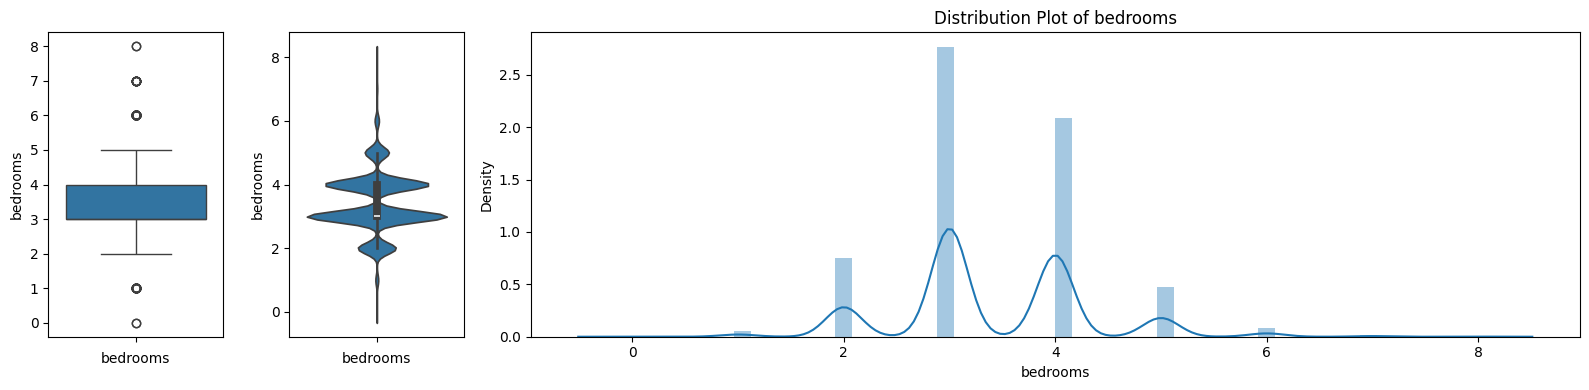

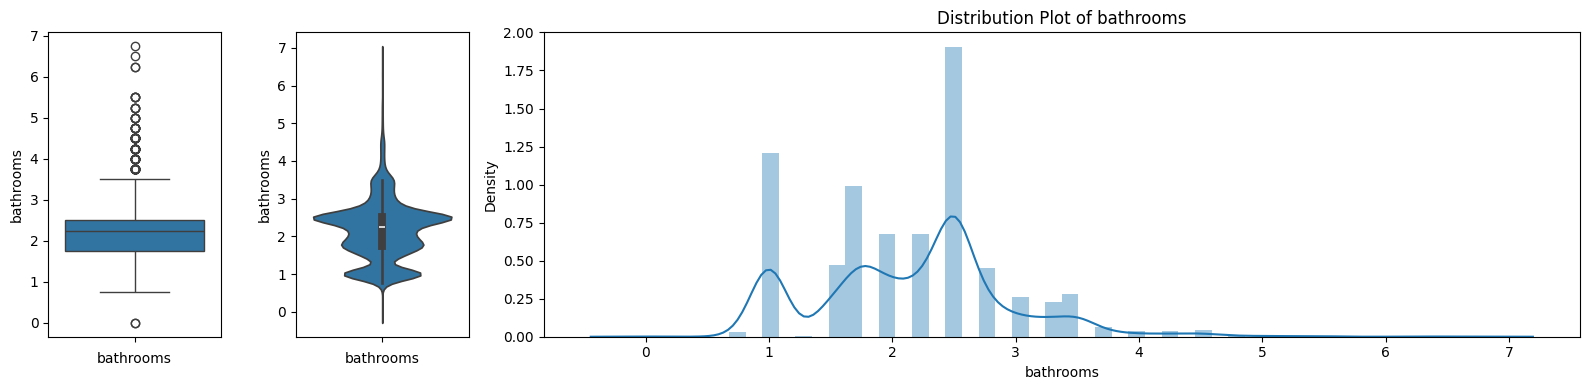

In [26]:
plot_numerical_features(train[numerical_features[1:3]])

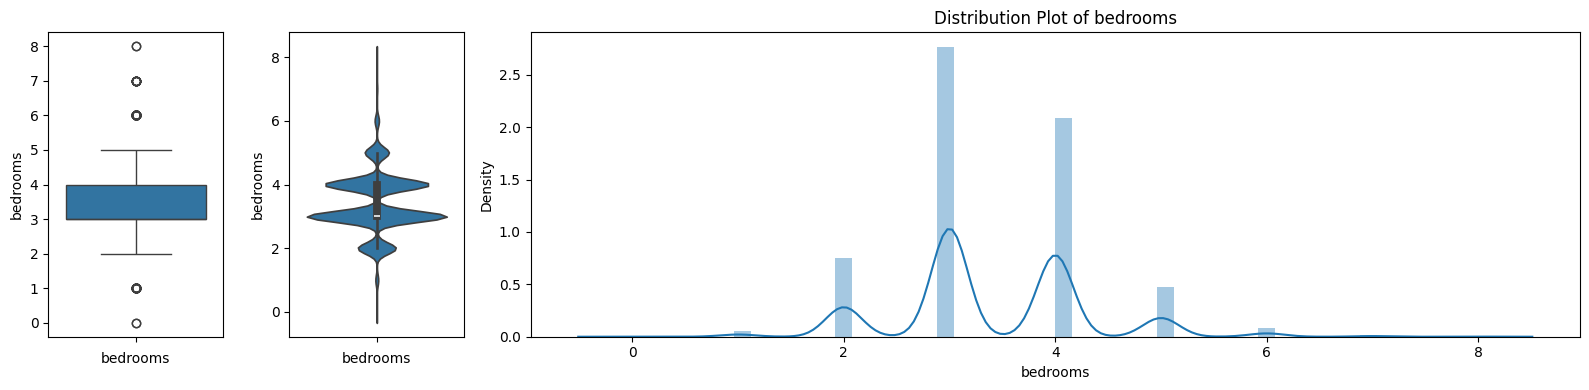

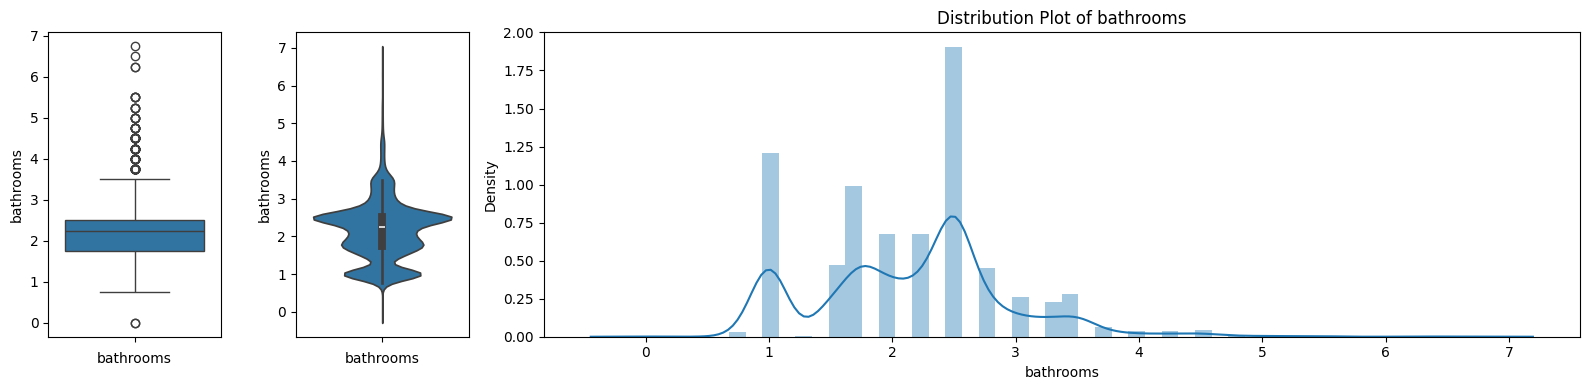

In [27]:
plot_numerical_features(train[numerical_features[1:3]])